# Fully convolutional network for semantic segmentation

Semantic segmentation belongs to scene understanding field, and it is the task of assigning meaning to a part of an object. This can be done at the pixel level where we assign each pixel to a target class.

The goal is to input an image into a neural network and output a category for every pixel. We'll have a set of categories, much like in a classification task. But instead of assigning a single class to an image we want to assign a class to every pixel in that image.

FCNs achieves state-of-art in tasks like semantic segmentation, by taking advantage of three special techniques:
- Replace fully connected layers with one by one convolutional layer.
- Up-sampling through the use of transposed convolutional layers.
- Adding skip connections. (This allows the network to use information from multiple resolution scales)

This network takes in an image that has true labels attached to each pixel and then it outputs a tensor with dimension:``` classes x height x width. ```

**FCN limitations**

- It is very expensive to label every pixel.
- It is computationally expensive to maintain spatial information in each convolutional layer.

## Set up Google Colab

### Connect with Google drive 

In [43]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Confirm that PIL works
Give **image_path** varible the path name of the image you want to display.

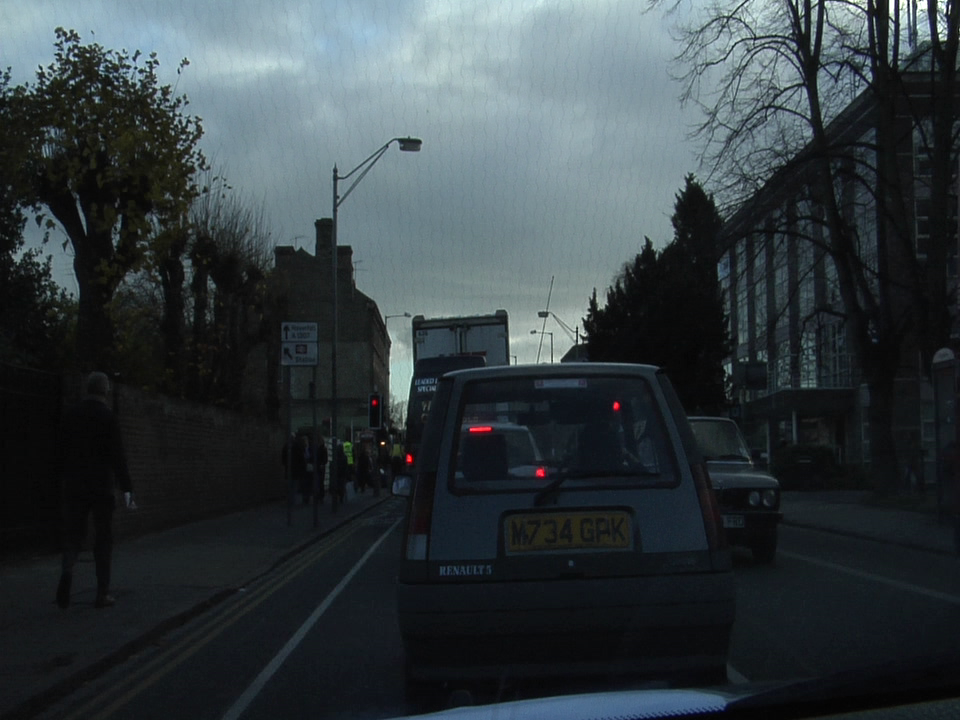

In [44]:
from PIL import Image
image_path = "/content/drive/MyDrive/Thesis (Image Segmentation)/FCN/CamVid/train/0001TP_009210.png"
Image.open(open(image_path,"rb"))

## Imports 

In [45]:
%matplotlib inline 


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.misc
import random
import imageio

import torch
import torch.nn as nn
import torch.functional as F
from torch import optim

from torchvision import models, datasets, transforms, utils
from torchvision.models.vgg import VGG
from torch.utils.data import Dataset

## Data

[CamVid](http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/) is a motion-based segmentation and recognition [dataset](https://github.com/mostafaizz/camvid) that contains 701 images, 701 labeled images, and a file with a list of classes with their correspondence in RGB code. 

**NOTE:** 
I pre-processed the labeled images by changing their RGB values for class ids. Instead of doing it directly on the CamVid class, do it separately and save the result as a .npy file to improve the performance ([Here](https://towardsdatascience.com/why-you-should-start-using-npy-file-more-often-df2a13cc0161) is an interesting article about that). In this way you cannot use PyTorch transforms on a label image, since PIL will change the class id for color values. Also, CamVid images are very similar, so adding augmentation like RandomCrop or RandomHorizontalFlip helps the network.

### Load data

In [46]:
class CamVid(Dataset):
  
  def __init__(self, csv_file, phase):
    self.phase = phase
    self.data = pd.read_csv(csv_file)
    
    if phase == 'train':
      self.input_shape = (480, 640)
    elif phase == 'valid':
      self.input_shape = (704, 960)
  
  def __getitem__(self, index):
    image, label = self.data.iloc[index, 0], self.data.iloc[index, 1]
    image = imageio.imread(image)
    label = np.load(label)
        
    if self.phase == "train":
      # RandomCrop
      h, w, _ = image.shape
      new_h, new_w = self.input_shape
      
      top = random.randint(0, h - new_h)
      left = random.randint(0, w - new_w)

      image = image[top:top + new_h, left:left + new_w]
      label = label[top:top + new_h, left:left + new_w]
      
      # RandomHorizontalFlip
      if random.random() < 0.5:
        image = np.fliplr(image)
        label = np.fliplr(label)
        
    if self.phase == "valid":
      # "Resize"
      new_h, new_w = self.input_shape
      
      image = image[0:new_h, 0:new_w]
      label = label[0:new_h, 0:new_w]
          
    # Normalization 
    mean=[0.485, 0.456, 0.460]
    std =[0.229, 0.224, 0.225]
    
    image = np.transpose(image, (2, 0, 1)) / 255.
    image[0] = (image[0] - mean[0]) / std[0]
    image[1] = (image[1] - mean[1]) / std[1]
    image[2] = (image[2] - mean[2]) / std[2]
    
    # ToTensor 
    image = torch.from_numpy(image.copy()).float()
    label = torch.from_numpy(label.copy()).long()
  
    # One-hot encoding
    h, w = label.size()
    target = torch.zeros(32, h, w)
    for c in range(32):
      target[c][label == c] = 1
      
    return {'x': image, 'y':target, 'l':label} 
  
  def __len__(self):
    return len(self.data) 

train_data = CamVid('/content/drive/MyDrive/Thesis (Image Segmentation)/FCN/CamVid/csv_files/train.csv', phase="train")
valid_data = CamVid('/content/drive/MyDrive/Thesis (Image Segmentation)/FCN/CamVid/csv_files/val.csv', phase="valid")

trainloader = torch.utils.data.DataLoader(train_data, batch_size=5, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=1)

### Visualize a single batch

torch.Size([5, 3, 480, 640]) torch.Size([5, 32, 480, 640]) torch.Size([5, 480, 640])


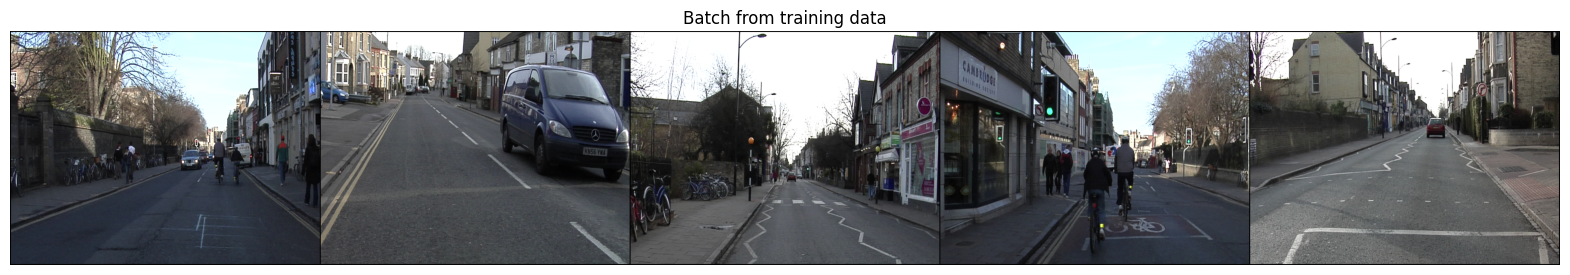

In [47]:
def show_batch(batch):
  mean=[0.485, 0.456, 0.460]
  std =[0.229, 0.224, 0.225]
  
  img_batch = batch['x']
 
  # Desnormalize 
  img_batch[:,0,...].mul_(std[0]).add_(mean[0])
  img_batch[:,1,...].mul_(std[1]).add_(mean[1])
  img_batch[:,2,...].mul_(std[2]).add_(mean[2])
  
  img_batch = np.clip(img_batch, 0, 1)
  grid = utils.make_grid(img_batch)
  
  plt.rcParams['figure.figsize'] = [20, 7.0]
  plt.figure()
  plt.title('Batch from training data')
  plt.imshow(grid.numpy().transpose((1, 2, 0)))
  plt.axis('off')
  plt.ioff()
  plt.show
    
batch = next(iter(trainloader))
print(batch['x'].size(), batch['y'].size(), batch['l'].size())
show_batch(batch)

## Model

### Encoder 

Its goal is to extract features from the image. In this case, I used the pretrained VGG16 model and removed the classifier (the fully connected layer at the end).  Doing so casts it into a fully convolutional network that outputs classification maps (heatmaps). Also saved the score of three different pooling layers that the decoder will use to perform skip connections.

In [48]:
class VGG16(VGG):
  
  def __init__(self, cfg, ranges, pretrained=True, model='vgg16', requires_grad=True, remove_fc=True, show_params=False):
    super().__init__(self.make_layers(cfg[model]))
    
    self.ranges = ranges[model]
        
    if pretrained:
      exec("self.load_state_dict(models.%s(pretrained=True).state_dict())" % model)
    if not requires_grad:
      for parameter in super().parameters():
        parameter.requires_grad = False
    if remove_fc: 
      del self.classifier
    if show_params:
      for name, parameter in self.named_parameters():
        print(name, parameter.size())
        
  def forward(self, x):
    output = {}
    
    # Get the output of each maxpooling layer (There are 5 in VGG) to create skip connections.
    for idx in range(len(self.ranges)):
      for layer in range(self.ranges[idx][0], self.ranges[idx][1]):
        x = self.features[layer](x)
      output["pool%d"%(idx+1)] = x
    
    return output 
  
  def make_layers(self, cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
      if v == 'M':
        layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
      else:
        conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
        if batch_norm:
          layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
        else:
          layers += [conv2d, nn.ReLU(inplace=True)]
        in_channels = v
    return nn.Sequential(*layers)

### Decoder 

It up-scales the output of the encoder such that it's the same size as the original image.

- **Convolutional score layer** - This will result in the output of a 4D tensor instead of a flattened 2D tensor, so spatial information will be preserved. Effectively, this turns convolutions into a matrix multiplication with spatial information. The number of kernels is equivalent to the number of outputs. 

- **Transposed convolutions** - Is essentially a reverse convolution in which the forward and the backward passes are swapped. They help in upsampling the previous layer to a higher resolution or dimension.  

- **Skip connections** - They allow the network to use information from multiple resolutions, and as a result, the network is able to make more precise segmentation decisions.

In [49]:
class FCN8s(nn.Module):
  
  def __init__(self, pretrained_model, n_classes):
    super().__init__()
    
    self.n_classes = n_classes
    self.pretrained_model = pretrained_model
    # Transposed convolutions (to upsampling previous layers)
    self.relu = nn.ReLU(inplace=True)
    self.deconv1 = nn.ConvTranspose2d(512, 512, 3, 2, padding=1, dilation=1, output_padding=1)
    self.bn1 = nn.BatchNorm2d(512)
    self.deconv2 = nn.ConvTranspose2d(512, 256, 3, 2, padding=1, dilation=1, output_padding=1)
    self.bn2 = nn.BatchNorm2d(256)
    self.deconv3 = nn.ConvTranspose2d(256, 128, 3, 2, padding=1, dilation=1, output_padding=1)
    self.bn3 = nn.BatchNorm2d(128)
    self.deconv4 = nn.ConvTranspose2d(128,  64, 3, 2, padding=1, dilation=1, output_padding=1)
    self.bn4 = nn.BatchNorm2d(64)
    self.deconv5 = nn.ConvTranspose2d( 64,  32, 3, 2, padding=1, dilation=1, output_padding=1)
    self.bn5 = nn.BatchNorm2d(32)
    # Convolutional score layer (replace the FC layers)
    self.score = nn.Conv2d(32, n_classes, 1)
  
  def forward(self, x):
    x = self.pretrained_model(x)
    
    # Skip connections (connect the output of one layer to a non-adjacent layer)
    pool_5 = x['pool5']
    pool_4 = x['pool4']
    pool_3 = x['pool3']
    
    x = self.relu(self.deconv1(pool_5))
    x = self.bn1(x + pool_4)
    x = self.relu(self.deconv2(x))
    x = self.bn2(x + pool_3)
    x = self.bn3(self.relu(self.deconv3(x)))
    x = self.bn4(self.relu(self.deconv4(x)))
    x = self.bn5(self.relu(self.deconv5(x)))
    x = self.score(x)
    
    return x

In [50]:
ranges = {'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31))}
cfg = {'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],}

###  Test output sizes

In [51]:
batch_size, n_classes, h, w = 10, 20, 160, 160

encoder = VGG16(cfg, ranges, requires_grad=True)
decoder = FCN8s(encoder, n_classes)

enc_input = torch.randn(batch_size, 3, 224, 224)
dec_input = torch.randn(batch_size, 3, h, w)

enc_output = encoder(enc_input)
dec_output = decoder(dec_input)

assert enc_output['pool5'].size() == torch.Size([batch_size, 512, 7, 7])
assert dec_output.size() == torch.Size([batch_size, n_classes, h, w])
print("Correct output sizes")

Correct output sizes


## Train model

### Test if the model works using a single batch

In [52]:
# fcn = FCN8s(VGG16(cfg,ranges), n_classes)

# criterion = nn.BCELoss()
# optimizer = optim.SGD(fcn.parameters(), lr=0.01, momentum=0.9)

# x = torch.randn(batch_size, 3, h, w)
# y = torch.randn(batch_size, n_classes, h, w)
# y = torch.tensor(y, requires_grad=False)

# for i in range(3):
#   optimizer.zero_grad()
#   output = fcn(x)
#   output = torch.sigmoid(output)
#   loss = criterion(output, y)
#   loss.backward()
#   print("i: {}, loss: {:.5f}".format(i, loss.item()))
#   optimizer.step()

### Set training parameters

In [53]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device 

device(type='cuda', index=0)

In [ ]:
# Define model
n_classes = 32
model = FCN8s(VGG16(cfg, ranges), n_classes)
model.to(device)

# Define training parameters
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.0001, momentum=0, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.5)
epochs = 50
print_every = 20

# Define scores
IoU_scores = np.zeros((epochs, n_classes))
pixel_scores = np.zeros(epochs)

### Check accuracy before training

In [ ]:
# def iou(y_hat, y):
#   ious = []
#   for c in range(n_classes):
#     pred_inds = y_hat == c
#     target_inds = y == c
#     intersection = pred_inds[target_inds].sum()
#     union = pred_inds.sum() + target_inds.sum() - intersection
#     if union == 0:
#       ious.append(float('nan')) # If there is no ground truth, do not include in evaluation
#     else:
#       ious.append(float(intersection) / max(union, 1))
#   return ious

# def pixel_accuracy(y_hat, y):
#   correct = (y_hat == y).sum()
#   total = (y == y).sum()
#   return correct/total


# def validation(model, validloader, criterion):
#   total_ious = []
#   pixel_accs = []
#   for i, batch in enumerate(validloader):
#     inputs = batch['x'].to(device)
#     output = model(inputs)
#     output = output.data.cpu().numpy()
        
#     N, _, h, w = output.shape 
#     pred = output.transpose(0, 2, 3, 1).reshape(-1, n_classes).argmax(axis=1).reshape(N, h, w)
#     target = batch['l'].cpu().numpy().reshape(N, h, w)
    
#     for y_hat, y in zip(pred, target):
#       total_ious.append(iou(y_hat, y))
#       pixel_accs.append(pixel_accuracy(y_hat, y))
  
#   # Pixel accuracy
#   pixel_acc = np.array(pixel_accs).mean()
  
#   # Mean IoU
#   total_ious = np.array(total_ious).T
#   mean_iou = np.nanmean(np.nanmean(total_ious, axis=1))
  
#   return pixel_acc, mean_iou

In [ ]:
# model.eval()
# with torch.no_grad():
#   pixel_acc, mean_iou = validation(model, validloader, criterion)
# model.train()
# print("Pixel accuracy: ", pixel_acc, " Mean IoU: ", mean_iou)

### Train

In [ ]:
# best = 0
# for epoch in range(epochs):
#   for i, batch in enumerate(trainloader):
#     inputs, labels = batch['x'].to(device), batch['y'].to(device)
#     optimizer.zero_grad()
    
#     outputs = model.forward(inputs)
#     loss = criterion(outputs, labels)
#     loss.backward()
#     optimizer.step()
#     if i % print_every == 0:
#       model.eval()
#       with torch.no_grad():
#         paccuracy, meaniou = validation(model, validloader, criterion)
#         print("Epoch: {}/{}.. ".format(epoch+1, epochs),
#               "Training loss: {:.5f}.. ".format(loss.item()),
#               "Pixel accuracy.. {:.5f}".format(paccuracy),
#               "Mean IU.. {:.5f}".format(meaniou))
#       if best < meaniou:
#         torch.save(model.state_dict(), "/content/drive/MyDrive/Thesis (Image Segmentation)/FCN/CamVid/weights/fcn-model-meaniuo-weight.pth")
#         best = meaniou
#       model.train()
  

### Check accuracy after training 

In [ ]:
# model.eval()
# with torch.no_grad():
#   pixel_acc, mean_iou = validation(model, validloader, criterion)
# model.train()
# print("Pixel accuracy: ", pixel_acc, " Mean IoU: ", mean_iou)

### Save model

In [ ]:
# torch.save(model.state_dict(), "/content/drive/MyDrive/Thesis (Image Segmentation)/FCN/CamVid/weights/fcn-model-weight.pth")

## Make inference

In [ ]:
state_dict = torch.load("/content/drive/MyDrive/Thesis (Image Segmentation)/FCN/CamVid/weights/fcn-model-meaniuo-weight-captum-maxpool.pth")
model.load_state_dict(state_dict)

In [ ]:
def plot_imgs(images = [], titles = [], figsize = (10,10)):
  size = len(images)
  fig = plt.figure(figsize=figsize)
  i = 1
  for image in images:
    ax = fig.add_subplot(1,size,i)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[i-1])
    ax.imshow(image)
    i += 1
  plt.show()
  return None
  
#Id : [Label, (RGB code)]
gt_labels = {1 : ["Animal", (64, 128, 64)],
            2 : ["Archway", (192, 0, 128)],
            3 : ["Bicyclist", (0, 128, 192)],
            4 : ["Bridge", (0, 128, 64)],
            5 : ["Building", (128, 0, 0,)],
            6 : ["Car", (64, 0, 128)],
            7 : ["CartLuggagePram", (64, 0, 192)],
            8 : ["Child", (192, 128, 64)],
            9 : ["Column_Pole", (192, 192, 128)],
            10: ["Fence", (64, 64, 128)],
            11: ["LaneMkgsDriv", (128, 0, 192)],
            12: ["LaneMkgsNonDriv", (192, 0, 64)],
            13: ["Misc_Text", (128, 128, 64)],
            14: ["MotorcycleScooter", (192, 0, 192)],
            15: ["OtherMoving", (128, 64, 64)],
            16: ["ParkingBlock", (64, 192, 128)],
            17: ["Pedestrian", (64, 64, 0)],
            18: ["Road", (128, 64, 128)],
            19: ["RoadShoulder", (128, 128, 192)],
            20: ["Sidewalk", (0, 0, 192)],
            21: ["SignSymbol", (192, 128, 128)],
            22: ["Sky", (128, 128, 128)],
            23: ["SUVPickupTruck", (64, 128, 192)],
            24: ["TrafficCone", (0, 0, 64)],
            25: ["TrafficLight", (0, 64, 64)],
            26: ["Train", (192, 64, 128)],
            27: ["Tree", (128, 128, 0)],
            28: ["Truck_Bus", (192, 128, 192)],
            29: ["Tunnel", (64, 0, 64)],
            30: ["VegetationMisc", (192, 192, 0)],
            31: ["Void", (0, 0, 0)],
            32: ["Wall", (64, 192, 0)]}	

In [ ]:
from PIL import Image
import warnings

warnings.filterwarnings("ignore")

inference_transforms = transforms.Compose([ transforms.Resize((704,960)),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.460],[0.229, 0.224, 0.225])])
def load_image(image):
  if isinstance(image, str):
    image = Image.open(image).convert('RGB')
  else:
    image = Image.fromarray(image).convert('RGB')
  image = inference_transforms(image)
  image = torch.tensor(image, requires_grad=False)
  image = image.unsqueeze(0)
  return image

def get_predicted_image(original, prediction, labels=None):
  _, h, w = prediction.shape
  _, oh, ow = original.shape
  if h != oh or w != ow:
    #original = scipy.misc.imresize(original, (704, 960))
    original = np.array(Image.fromarray(original).resize((704, 960)))
    #numpy.array(Image.fromarray(arr).resize())
  output = np.zeros((h, w, 3), dtype=np.uint8)
  for i in range(h):
    for j in range(w):
      index = prediction[0][i][j] + 1
      try:
        if labels is not None:
          if index in labels:
            color = gt_labels.get(index)[1]
            output[i, j, 0] = color[0]
            output[i, j, 1] = color[1]
            output[i, j, 2] = color[2]
          else:
            output[i, j, 0] = original[i, j, 0]
            output[i, j, 1] = original[i, j, 1]
            output[i, j, 2] = original[i, j, 2]
        else:
          color = gt_labels.get(index)[1]
          output[i, j, 0] = color[0]
          output[i, j, 1] = color[1]
          output[i, j, 2] = color[2]
      except:
        print("Upss, didn't work")
        break
  return output

def get_image_labels(testimage):
  model.to(device)
  model.eval()
  image = load_image(testimage)
  prediction = model(image.to(device))
  prediction = prediction.data.cpu().numpy()
  N, _, h, w = prediction.shape
  prediction = prediction.transpose(0, 2, 3, 1).reshape(-1, 32).argmax(axis=1).reshape(N, h, w)
  return prediction

### Compare prediction with ground truth

In [ ]:
name = "Seq05VD_f01800"

inp_image = "/content/drive/MyDrive/Thesis (Image Segmentation)/FCN/CamVid/train/" + name + ".png"
tru_image = "/content/drive/MyDrive/Thesis (Image Segmentation)/FCN/CamVid/train_labels/" + name + "_L.png"

original = imageio.imread(inp_image)
truth = imageio.imread(tru_image)
predicted = get_predicted_image(original, get_image_labels(inp_image))

plot_imgs([original, truth, predicted], ["Original", "Ground truth", "Prediction"], (15, 15))

### Predict on an unlabeled image 

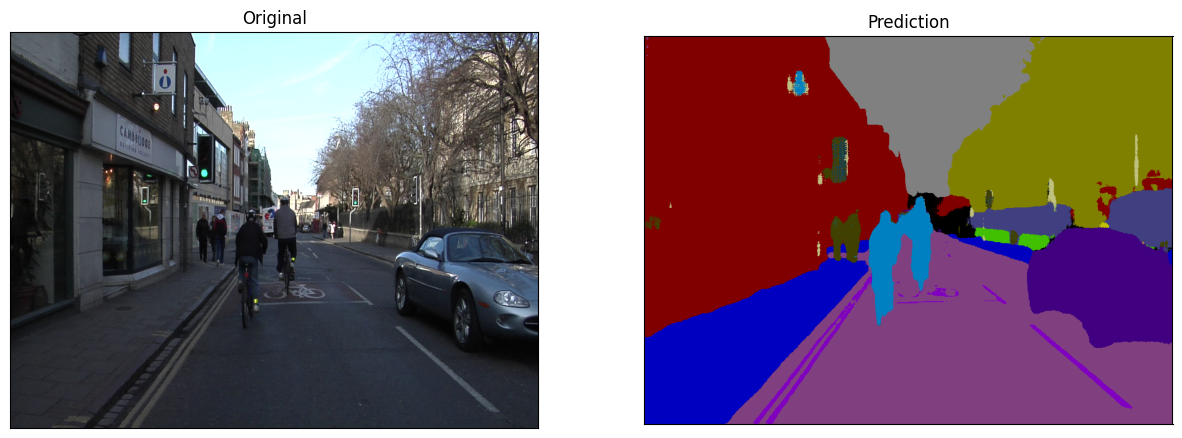

In [ ]:
inp_image = "/content/drive/MyDrive/Thesis (Image Segmentation)/FCN/CamVid/val/0016E5_08045.png"

original = imageio.imread(inp_image)
predicted = get_predicted_image(original, get_image_labels(inp_image))
   
plot_imgs([original, predicted], ["Original", "Prediction"], (15, 15))

In [ ]:
# print(model)
# model.pretrained_model.features[28]

In [ ]:
# !pip install captum

In [ ]:
from captum.attr import visualization as viz
from captum.attr import LayerGradCam, FeatureAblation, LayerActivation, LayerAttribution

In [ ]:
# Input preprocessing transformation
preprocessing = transforms.Compose([transforms.Resize((704,960)), 
                                    transforms.ToTensor()])
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

In [ ]:
# This method allows us to visualize a particular segmentation output, by setting
# each pixels color according to the given segmentation class provided in the 
# image (segmentation output).
def decode_segmap(image, nc=32):  
    
    label_colors = np.array([(64, 128, 64),
                          (192, 0, 128),
                          (0, 128, 192),
                          (0, 128, 64),
                          (128, 0, 0,),
                          (64, 0, 128),
                          (64, 0, 192),
                          (192, 128, 64),
                          (192, 192, 128),
                          (64, 64, 128),
                          (128, 0, 192),
                          (192, 0, 64),
                          (128, 128, 64),
                          (192, 0, 192),
                          (128, 64, 64),
                          (64, 192, 128),
                          (64, 64, 0),
                          (128, 64, 128),
                          (128, 128, 192),
                          (0, 0, 192),
                          (192, 128, 128),
                          (128, 128, 128),
                          (64, 128, 192),
                          (0, 0, 64),
                          (0, 64, 64),
                          (192, 64, 128),
                          (128, 128, 0),
                          (192, 128, 192),
                          (64, 0, 64),
                          (192, 192, 0),
                          (0, 0, 0),
                          (64, 192, 0)])

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb

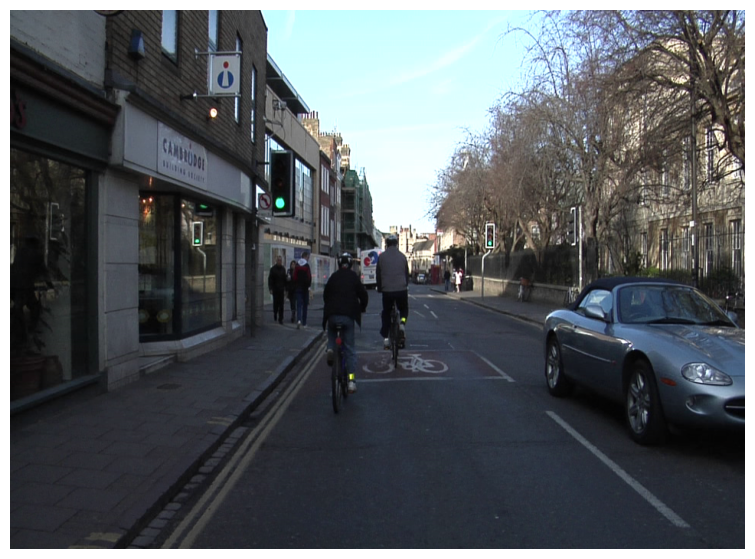

In [ ]:
img = Image.open("/content/drive/MyDrive/Thesis (Image Segmentation)/FCN/CamVid/val/0016E5_08045.png")
preproc_img = preprocessing(img)
plt.imshow(preproc_img.permute(1,2,0)); plt.axis('off'); plt.show()

In [ ]:
inp_image = "/content/drive/MyDrive/Thesis (Image Segmentation)/FCN/CamVid/val/0016E5_08045.png"
model.to(device)
model.eval()
image = load_image(inp_image)
out = model(image.to(device))
out_max = torch.argmax(out, dim=1, keepdim=True)
rgb = decode_segmap(out_max.detach().cpu().squeeze().numpy())
plt.imshow(rgb); plt.axis('off'); plt.show()

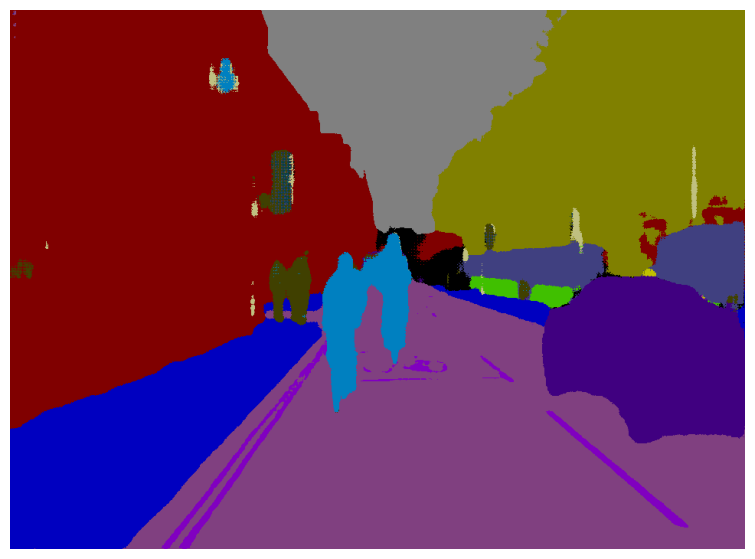

In [ ]:
# Normalize image and compute segmentation output
#normalized_inp = normalize(preproc_img).unsqueeze(0).to(device)
normalized_inp = load_image(img).to(device)
normalized_inp.requires_grad = True
model.to(device)
model.eval()
out = model(normalized_inp)

# Find most likely segmentation class for each pixel.
out_max = torch.argmax(out, dim=1, keepdim=True)

# Visualize segmentation output using utility method.
rgb = decode_segmap(out_max.detach().cpu().squeeze().numpy())
plt.imshow(rgb); plt.axis('off'); plt.show()


In [ ]:
"""
This wrapper computes the segmentation model output and sums the pixel scores for
all pixels predicted as each class, returning a tensor with a single value for
each class. This makes it easier to attribute with respect to a single output
scalar, as opposed to an individual pixel output attribution.
"""
def agg_segmentation_wrapper(inp):
    model_out = model(inp)
    # Creates binary matrix with 1 for original argmax class for each pixel
    # and 0 otherwise. Note that this may change when the input is ablated
    # so we use the original argmax predicted above, out_max.
    selected_inds = torch.zeros_like(model_out[0:1]).scatter_(1, out_max, 1)
    return (model_out * selected_inds).sum(dim=(2,3))


# Alternate wrapper, simply summing each output channel
# def wrapper(inp):
#   return fcn(inp)['out'].sum(dim=(2,3))


In [ ]:
lgc = LayerGradCam(agg_segmentation_wrapper, model.pretrained_model.features[28])

In [ ]:
gc_attr = lgc.attribute(normalized_inp, target=6)

In [ ]:
gc_attr = lgc.attribute(normalized_inp, target=6)

In [ ]:
la = LayerActivation(agg_segmentation_wrapper, model.pretrained_model.features[28])
activation = la.attribute(normalized_inp)
print("Input Shape:", normalized_inp.shape)
print("Layer Activation Shape:", activation.shape)
print("Layer GradCAM Shape:", gc_attr.shape)

Input Shape: torch.Size([1, 3, 704, 960])
Layer Activation Shape: torch.Size([1, 512, 44, 60])
Layer GradCAM Shape: torch.Size([1, 1, 44, 60])


In [ ]:
viz.visualize_image_attr(gc_attr[0].cpu().permute(1,2,0).detach().numpy(),sign="all")

AssertionError: ignored